In [4]:
#Install Libs

In [6]:
#pip install langgraph
#pip install langchain-nomic
#pip install -U langchain-ollama
#pip install tiktoken
#pip install langchain-community
#pip install gpt4all

In [8]:
#imports

In [10]:
import ollama
from langchain_nomic import *
import langchain_community
import os
import re
import getpass
import json
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_community.tools.tavily_search import TavilySearchResults
import operator
from typing_extensions import TypedDict
from typing import List, Annotated
import langgraph
from langchain.schema import Document
from langgraph.graph import END
from langgraph.graph import StateGraph
from IPython.display import Image, display
from langchain_ollama import ChatOllama
from gpt4all import GPT4All

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
response = ollama.pull(model="llama3.2:3b-instruct-fp16")

response

{'status': 'success'}

In [9]:


local_llm = "llama3.2:3b-instruct-fp16"
llm = ChatOllama(model=local_llm, temperature=0)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json")

In [11]:



def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("TAVILY_API_KEY")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

TAVILY_API_KEY:  ········


In [13]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "local-llama32-rag"

LANGCHAIN_API_KEY:  ········


In [17]:

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
)

# Create retriever
retriever = vectorstore.as_retriever(k=3)

USER_AGENT environment variable not set, consider setting it to identify your requests.
Downloading: 100%|██████████| 274M/274M [00:09<00:00, 29.7MiB/s] 
Verifying: 100%|██████████| 274M/274M [00:00<00:00, 664MiB/s] 


In [19]:
### Router


# Prompt
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.

The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.

Use the vectorstore for questions on these topics. For all else, and especially for current events, use web-search.

Return JSON with single key, datasource, that is 'websearch' or 'vectorstore' depending on the question."""

# Test router
test_web_search = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [
        HumanMessage(
            content="Who is favored to win the NFC Championship game in the 2024 season?"
        )
    ]
)
test_web_search_2 = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="What are the models released today for llama3.2?")]
)
test_vector_store = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="What are the types of agent memory?")]
)
print(
    json.loads(test_web_search.content),
    json.loads(test_web_search_2.content),
    json.loads(test_vector_store.content),
)

{'datasource': 'websearch'} {'datasource': 'websearch'} {'datasource': 'vectorstore'}


In [21]:
### Retrieval Grader

# Doc grader instructions
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

# Grader prompt
doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 

This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""

# Test
question = "What is Chain of thought prompting?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
doc_grader_prompt_formatted = doc_grader_prompt.format(
    document=doc_txt, question=question
)
result = llm_json_mode.invoke(
    [SystemMessage(content=doc_grader_instructions)]
    + [HumanMessage(content=doc_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'yes'}

In [23]:
### Generate

# Prompt
rag_prompt = """You are an assistant for question-answering tasks. 

Here is the context to use to answer the question:

{context} 

Think carefully about the above context. 

Now, review the user question:

{question}

Provide an answer to this questions using only the above context. 

Use three sentences maximum and keep the answer concise.

Answer:"""


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Test
docs = retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
print(generation.content)

Chain of Thought (CoT) prompting is a technique used in natural language processing to generate human-like responses by iteratively asking questions and refining the search space through external search queries, such as Wikipedia APIs. CoT prompting involves decomposing problems into multiple thought steps, generating multiple thoughts per step, and evaluating each state using a classifier or majority vote. The goal is to find an optimal instruction that leads to the desired output, which can be achieved by optimizing prompt parameters directly on the embedding space via gradient descent or searching over a pool of model-generated instruction candidates.


In [25]:
### Hallucination Grader

# Hallucination grader instructions
hallucination_grader_instructions = """

You are a teacher grading a quiz. 

You will be given FACTS and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS. 

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS. And a key, explanation, that contains an explanation of the score."""

# Test using documents and generation from above
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
    documents=docs_txt, generation=generation.content
)
result = llm_json_mode.invoke(
    [SystemMessage(content=hallucination_grader_instructions)]
    + [HumanMessage(content=hallucination_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': 'The student answer provides a clear and accurate description of Chain of Thought (CoT) prompting, its components, and its goals. It also mentions various techniques used in CoT prompting, such as external search queries, prompt tuning, and automatic prompt engineering. The answer demonstrates an understanding of the concept and its applications in natural language processing.'}

In [27]:
### Answer Grader

# Answer grader instructions
answer_grader_instructions = """You are a teacher grading a quiz. 

You will be given a QUESTION and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) The STUDENT ANSWER helps to answer the QUESTION

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, that contains an explanation of the score."""

# Test
question = "What are the vision models released today as part of Llama 3.2?"
answer = "The Llama 3.2 models released today include two vision models: Llama 3.2 11B Vision Instruct and Llama 3.2 90B Vision Instruct, which are available on Azure AI Model Catalog via managed compute. These models are part of Meta's first foray into multimodal AI and rival closed models like Anthropic's Claude 3 Haiku and OpenAI's GPT-4o mini in visual reasoning. They replace the older text-only Llama 3.1 models."

# Test using question and generation from above
answer_grader_prompt_formatted = answer_grader_prompt.format(
    question=question, generation=answer
)
result = llm_json_mode.invoke(
    [SystemMessage(content=answer_grader_instructions)]
    + [HumanMessage(content=answer_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': "The student's answer helps to answer the question by providing specific details about the vision models released as part of Llama 3.2. The answer mentions two vision models (Llama 3.2 11B Vision Instruct and Llama 3.2 90B Vision Instruct) and their availability on Azure AI Model Catalog via managed compute. Additionally, the student provides context about Meta's first foray into multimodal AI and compares these models to other visual reasoning models like Claude 3 Haiku and GPT-4o mini. This extra information is not explicitly asked for in the question, but it demonstrates a thorough understanding of the topic. The answer also correctly states that these models replace the older text-only Llama 3.1 models, which meets all the criteria specified in the question."}

In [29]:
### Search
web_search_tool = TavilySearchResults(k=3)

In [31]:

class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """

    question: str  # User question
    generation: str  # LLM generation
    web_search: str  # Binary decision to run web search
    max_retries: int  # Max number of retries for answer generation
    answers: int  # Number of answers generated
    loop_step: Annotated[int, operator.add]
    documents: List[str]  # List of retrieved documents

In [81]:


def retrieve(state):
    """Retrieve documents from vectorstore."""
    print("---RETRIEVE---")
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents}

def generate(state):
    """Generate answer using RAG on retrieved documents."""
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"answer": generation.content}

def grade_documents(state):
    """Determine if retrieved documents are relevant to the question."""
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    filtered_docs = []
    web_search = "No"
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=question
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        if grade.lower() == "yes":
            filtered_docs.append(d)
        else:
            web_search = "Yes"
    return {"documents": filtered_docs, "web_search": web_search}

def web_search(state):
    """Perform web search based on the question."""
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])
    docs = web_search_tool.invoke({"query": question})

    # Collecting the web results and sources
    web_sources = []
    for d in docs:
        if "content" in d:
            web_results_doc = Document(page_content=d["content"])
            documents.append(web_results_doc)
        if "source" in d:
            web_sources.append(d["source"])

    # If no sources found, add a default message
    if not web_sources and docs:
        web_sources.append("Source not available")

    return {"documents": documents, "web_sources": web_sources}

def route_question(state):
    """Route question to web search or RAG."""
    print("---ROUTE QUESTION---")
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    source = json.loads(route_question.content)["datasource"]
    return "websearch" if source == "websearch" else "vectorstore"

def decide_to_generate(state):
    """Decide whether to generate an answer or add web search."""
    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]
    return "websearch" if web_search == "Yes" else "generate"

def process_question(question):
    """Process the question and return the final answer with citations if applicable."""
    state = {"question": question, "max_retries": 3, "loop_step": 0}
    next_node = route_question(state)

    while next_node != END:
        if next_node == "vectorstore":
            state.update(retrieve(state))
            state.update(grade_documents(state))
            next_node = decide_to_generate(state)
        elif next_node == "websearch":
            state.update(web_search(state))
            state.update(grade_documents(state))
            next_node = decide_to_generate(state)
        elif next_node == "generate":
            state.update(generate(state))
            answer = state["answer"]
            # Check if web results were involved and provide citations
            if state.get("web_sources"):
                citations = f"\nCitations:\n{state['web_sources'][0]}"
                print(f"Final Answer: {answer}{citations}")
            else:
                print(f"Final Answer: {answer}")
            return answer
        else:
            raise ValueError("Unknown next node: {}".format(next_node))

    print("No answer could be generated.")
    return None



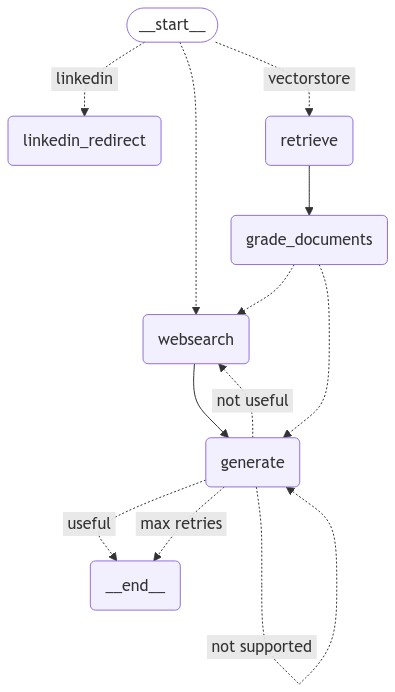

In [97]:


# Define the workflow graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("linkedin_redirect", lambda state: {"answer": f"https://in.linkedin.com/in/{state['person_name'].replace(' ', '-')}"} )  # LinkedIn redirect

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "linkedin": "linkedin_redirect",  # Direct to LinkedIn if the query is about a person
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [83]:
# Example usage:
questions = input("Please enter your question: ")
process_question(questions)

Please enter your question:  who is indrajit kar


---ROUTE QUESTION---
---WEB SEARCH---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---GENERATE---
Final Answer: Indrajit Kar is a master's graduate in Computational Biology from Bengaluru with over 22 years of experience in AI and ML. He has held various leadership positions at prominent companies such as Siemens, Accenture, IBM, Infinite Data Systems, and Zensar Technologies. As the Head of AI at Siemens Advanta, he influences CXOs and organizations with data-driven decision making and leads teams responsible for emerging technologies.
Citations:
Source not available


"Indrajit Kar is a master's graduate in Computational Biology from Bengaluru with over 22 years of experience in AI and ML. He has held various leadership positions at prominent companies such as Siemens, Accenture, IBM, Infinite Data Systems, and Zensar Technologies. As the Head of AI at Siemens Advanta, he influences CXOs and organizations with data-driven decision making and leads teams responsible for emerging technologies."

In [105]:



def retrieve(state):
    """Retrieve documents from vectorstore."""
    print("---RETRIEVE---")
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents}

def generate(state):
    """Generate answer using RAG on retrieved documents."""
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"answer": generation.content}

def grade_documents(state):
    """Determine if retrieved documents are relevant to the question."""
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    filtered_docs = []
    web_search = "No"
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=question
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        if grade.lower() == "yes":
            filtered_docs.append(d)
        else:
            web_search = "Yes"
    return {"documents": filtered_docs, "web_search": web_search}

def web_search(state):
    """Perform web search based on the question."""
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])
    docs = web_search_tool.invoke({"query": question})

    # Collecting the web results and sources
    web_sources = []
    for d in docs:
        if "content" in d:
            web_results_doc = Document(page_content=d["content"])
            documents.append(web_results_doc)
        if "link" in d:  # Assuming "link" holds the URL of the source
            web_sources.append(d["link"])

    # If no sources found, add a default message
    if not web_sources and docs:
        web_sources.append("Source not available")

    return {"documents": documents, "web_sources": web_sources}

def route_question(state):
    """Route question based on content: check vectorstore, then web search, then LinkedIn."""
    print("---ROUTE QUESTION---")
    question = state["question"]

    # Check if the question is about a person using regex
    person_keywords = re.compile(r"(who is|tell me about|profile of|bio of|biography of) (.+)", re.IGNORECASE)
    match = person_keywords.match(question)

    if match:
        person_name = match.group(2).strip().replace(" ", "-")
        linkedin_url = f"https://in.linkedin.com/in/{person_name}"
        return {"datasource": "linkedin", "linkedin_url": linkedin_url}
    else:
        # Default to vector store first
        return "vectorstore"

def decide_to_generate(state):
    """Decide whether to generate an answer or add web search."""
    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]
    return "websearch" if web_search == "Yes" else "generate"

def process_question(question):
    """Process the question and return the final answer with citations if applicable."""
    state = {"question": question, "max_retries": 3, "loop_step": 0}
    next_node = route_question(state)

    if isinstance(next_node, dict) and next_node.get("datasource") == "linkedin":
        # Handle LinkedIn direct link for person queries
        linkedin_url = next_node["linkedin_url"]
        print(f"Final Answer: You can view the LinkedIn profile here: {linkedin_url}")
        return linkedin_url

    while next_node != END:
        if next_node == "vectorstore":
            state.update(retrieve(state))
            state.update(grade_documents(state))
            next_node = decide_to_generate(state)
        elif next_node == "websearch":
            state.update(web_search(state))
            state.update(grade_documents(state))
            next_node = decide_to_generate(state)
        elif next_node == "generate":
            state.update(generate(state))
            answer = state["answer"]
            # Check if web results were involved and provide citations
            if state.get("web_sources"):
                citations = f"\nCitations:\n{state['web_sources'][0]}"
                print(f"Final Answer: {answer}{citations}")
            else:
                print(f"Final Answer: {answer}")
            return answer
        else:
            raise ValueError("Unknown next node: {}".format(next_node))

    print("No answer could be generated.")
    return None



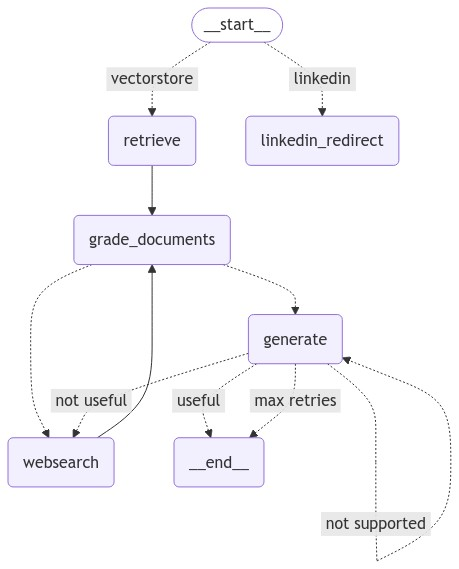

In [107]:


# Define the workflow graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node(
    "linkedin_redirect",
    lambda state: {"answer": f"https://in.linkedin.com/in/{state['person_name'].replace(' ', '-')}"}
)  # LinkedIn redirect

# Define the conditional entry point for routing
def custom_route_question(state):
    """Custom routing based on question type."""
    question = state["question"]
    person_keywords = re.compile(r"(who is|tell me about|profile of|bio of|biography of) (.+)", re.IGNORECASE)
    match = person_keywords.match(question)

    if match:
        person_name = match.group(2).strip()
        state["person_name"] = person_name
        return "linkedin"
    else:
        return "vectorstore"

# Build graph
workflow.set_conditional_entry_point(
    custom_route_question,
    {
        "linkedin": "linkedin_redirect",  # Direct to LinkedIn if the query is about a person
        "vectorstore": "retrieve",
    },
)

# Add edges for web search and document grading/generation process
workflow.add_edge("websearch", "grade_documents")  # Add grading after web search
workflow.add_edge("retrieve", "grade_documents")  # Grade documents after retrieval

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",  # If documents are not sufficient, do a web search
        "generate": "generate",  # If documents are sufficient, proceed to generate an answer
    },
)

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",  # Retry generation if the answer is unsupported
        "useful": END,  # End if the answer is useful
        "not useful": "websearch",  # Perform web search if the answer is not useful
        "max retries": END,  # End if max retries have been reached
    },
)

# Compile the graph and display it
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [119]:
# Example usage:
questions = input("Please enter your question: ")
process_question(questions)

Please enter your question:  Who is Indrajit Kar


---ROUTE QUESTION---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---WEB SEARCH---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---GENERATE---
Final Answer: Indrajit Kar is a master's graduate in Computational Biology from Bengaluru with over 22 years of experience in AI and ML, having worked at various organizations including Siemens, Accenture, IBM, Infinite Data Systems, and Zensar Technologies. He currently serves as the Head of AI at Siemens Advanta, where he influences CXOs and organizations to adopt data-driven decision making. Indrajit Kar is also a book author and editor, with 21 patents related to AI and Generative AI.
Citations:
Source not available


"Indrajit Kar is a master's graduate in Computational Biology from Bengaluru with over 22 years of experience in AI and ML, having worked at various organizations including Siemens, Accenture, IBM, Infinite Data Systems, and Zensar Technologies. He currently serves as the Head of AI at Siemens Advanta, where he influences CXOs and organizations to adopt data-driven decision making. Indrajit Kar is also a book author and editor, with 21 patents related to AI and Generative AI."

In [136]:


def retrieve(state):
    """Retrieve documents from vectorstore."""
    print("---RETRIEVE---")
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents}

def generate(state):
    """Generate answer using RAG on retrieved documents."""
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"answer": generation.content}

def grade_documents(state):
    """Determine if retrieved documents are relevant to the question."""
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    filtered_docs = []
    web_search = "No"
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=question
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        if grade.lower() == "yes":
            filtered_docs.append(d)
        else:
            web_search = "Yes"
    return {"documents": filtered_docs, "web_search": web_search}

def web_search(state):
    """Perform web search based on the question."""
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])
    docs = web_search_tool.invoke({"query": question})

    # Collecting the web results and sources
    web_sources = []
    for d in docs:
        if "content" in d:
            web_results_doc = Document(page_content=d["content"])
            documents.append(web_results_doc)
        if "link" in d:  # Assuming "link" holds the URL of the source
            web_sources.append(d["link"])

    # If no sources found, add a default message
    if not web_sources and docs:
        web_sources.append("Source not available")

    return {"documents": documents, "web_sources": web_sources}

def route_question(state):
    """Route question based on content: check vectorstore, then web search, then LinkedIn."""
    print("---ROUTE QUESTION---")
    question = state["question"]

    # Check if the question is about a person using regex
    person_keywords = re.compile(r"(who is|tell me about|profile of|bio of|biography of) (.+)", re.IGNORECASE)
    match = person_keywords.match(question)

    if match:
        state["person_name"] = match.group(2).strip()
        return "vectorstore"
    else:
        return "vectorstore"

def decide_to_generate(state):
    """Decide whether to generate an answer, add web search, or go to LinkedIn."""
    print("---ASSESS GRADED DOCUMENTS---")
    if not state["documents"]:
        return "websearch"
    elif state["web_search"] == "Yes":
        return "websearch"
    else:
        return "generate"

def process_question(question):
    """Process the question and return the final answer with citations if applicable."""
    state = {"question": question, "max_retries": 3, "loop_step": 0}
    next_node = route_question(state)

    while next_node != END:
        if next_node == "vectorstore":
            state.update(retrieve(state))
            state.update(grade_documents(state))
            next_node = decide_to_generate(state)
        elif next_node == "websearch":
            state.update(web_search(state))
            state.update(grade_documents(state))
            next_node = decide_to_generate(state)
        elif next_node == "generate":
            state.update(generate(state))
            answer = state["answer"]

            # Add LinkedIn link if the question is about a person
            linkedin_link = ""
            if "person_name" in state:
                person_name = state["person_name"].replace(" ", "-")
                linkedin_link = f"\nLinkedIn Profile: https://in.linkedin.com/in/{person_name}"

            # Check if web results were involved and provide citations
            if state.get("web_sources"):
                citations = f"\nCitations:\n{state['web_sources'][0]}"
                print(f"Final Answer: {answer}{citations}{linkedin_link}")
            else:
                print(f"Final Answer: {answer}{linkedin_link}")
            return answer
        elif next_node == "linkedin_redirect":
            person_name = state["person_name"].replace(" ", "-")
            linkedin_url = f"https://in.linkedin.com/in/{person_name}"
            print(f"Final Answer: You can view the LinkedIn profile here: {linkedin_url}")
            return linkedin_url
        else:
            raise ValueError("Unknown next node: {}".format(next_node))

    print("No answer could be generated.")
    return None



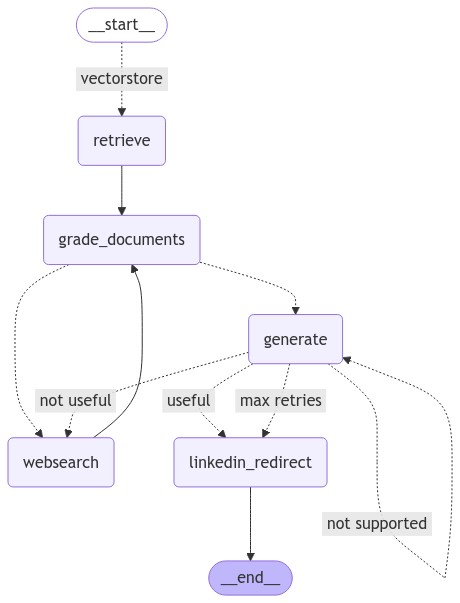

In [140]:


# Define the workflow graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node(
    "linkedin_redirect",
    lambda state: {"linkedin_url": f"https://in.linkedin.com/in/{state['person_name'].replace(' ', '-')}"}
)  # LinkedIn redirect

# Define the conditional entry point for routing
def custom_route_question(state):
    """Custom routing based on question type."""
    question = state["question"]
    person_keywords = re.compile(r"(who is|tell me about|profile of|bio of|biography of) (.+)", re.IGNORECASE)
    match = person_keywords.match(question)

    if match:
        person_name = match.group(2).strip()
        state["person_name"] = person_name
        return "vectorstore"
    else:
        return "vectorstore"

# Build graph
workflow.set_conditional_entry_point(
    custom_route_question,
    {
        "vectorstore": "retrieve",  # Start with vector store retrieval
    },
)

# Add edges for document retrieval and grading process
workflow.add_edge("retrieve", "grade_documents")  # Grade documents after retrieval

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",  # If documents are not sufficient, do a web search
        "generate": "generate",  # If documents are sufficient, proceed to generate an answer
    },
)

# Add web search and grading edge
workflow.add_edge("websearch", "grade_documents")  # Add grading after web search

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",  # Retry generation if the answer is unsupported
        "useful": "linkedin_redirect",  # Proceed to LinkedIn redirect if the answer is useful
        "not useful": "websearch",  # Perform web search if the answer is not useful
        "max retries": "linkedin_redirect",  # Redirect to LinkedIn if max retries are reached
    },
)

# Ensure LinkedIn link is provided, even if sufficient info found
workflow.add_edge("linkedin_redirect", END)  # End after providing LinkedIn link

# Compile the graph and display it
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [158]:
# Example usage:
questions = input("Please enter your question: ")
process_question(questions)

Please enter your question:  who is Indrajit Kar


---ROUTE QUESTION---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---WEB SEARCH---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---GENERATE---
Final Answer: Indrajit Kar is a master's graduate in Computational Biology from Bengaluru with over 22 years of experience in AI and ML, having worked at various companies including Siemens, Accenture, IBM, Infinite Data Systems, and Zensar Technologies. He currently serves as the Head of AI at Siemens Advanta, where he influences CXOs and organizations to adopt data-driven decision making. Indrajit Kar is also a book author and editor, with 21 patents related to AI and Generative AI.
Citations:
Source not available
LinkedIn Profile: https://in.linkedin.com/in/Indrajit-Kar


"Indrajit Kar is a master's graduate in Computational Biology from Bengaluru with over 22 years of experience in AI and ML, having worked at various companies including Siemens, Accenture, IBM, Infinite Data Systems, and Zensar Technologies. He currently serves as the Head of AI at Siemens Advanta, where he influences CXOs and organizations to adopt data-driven decision making. Indrajit Kar is also a book author and editor, with 21 patents related to AI and Generative AI."

In [160]:
# Example usage:
questions = input("Please enter your question: ")
process_question(questions)

Please enter your question:  what is Open AI swarm?


---ROUTE QUESTION---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---WEB SEARCH---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---GENERATE---
Final Answer: OpenAI Swarm is an open-source framework designed to simplify the creation and coordination of AI agents, focusing on agent coordination and execution through agents and handoffs. It is a flexible and efficient framework for orchestrating multiple AI agents, aiming to explore user-friendly interfaces for managing complex multi-agent systems. The framework is currently in its experimental phase, showcasing advances encompassing agentic AI.
Citations:
Source not available


'OpenAI Swarm is an open-source framework designed to simplify the creation and coordination of AI agents, focusing on agent coordination and execution through agents and handoffs. It is a flexible and efficient framework for orchestrating multiple AI agents, aiming to explore user-friendly interfaces for managing complex multi-agent systems. The framework is currently in its experimental phase, showcasing advances encompassing agentic AI.'